In [2]:
# Import libraries

import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3' 
from urllib import request

import numpy
from numpy import random
import tensorflow
from tensorflow import keras
import sklearn
from sklearn import model_selection

from matplotlib import pyplot

import keras_tuner

/usr/lib/python3.11/site-packages/h5py/__init__.py:36: UserWarning: h5py is running against HDF5 1.14.1 when it was built against 1.14.0, this may cause problems
  _warn(("h5py is running against HDF5 {0} when it was built against {1}, "


In [2]:
# Download data

enhancers_filename="enhancers.fasta"
nonenhancers_filename="nonenhancers.fasta"

if not os.path.exists(enhancers_filename):
    request.urlretrieve("https://raw.githubusercontent.com/feng-123/Enhancer-LSTMAtt/master/data/layer1/enhancer.cv.txt", enhancers_filename)
    print("Downloaded", enhancers_filename)
    
if not os.path.exists(nonenhancers_filename):
    request.urlretrieve("https://raw.githubusercontent.com/feng-123/Enhancer-LSTMAtt/master/data/layer1/non.cv.txt", nonenhancers_filename)
    print("Downloaded", nonenhancers_filename)

In [52]:
# Generate random seed for shuffling the data during the split

split_seed=random.randint(256)
print("Seed for shuffling data:",split_seed)

Seed for shuffling data: 78


In [4]:
# Make training data and test data

enhancers_filename="enhancers.fasta"
nonenhancers_filename="nonenhancers.fasta"

x_data = []
y_data = []

sequence_length=200

with open(enhancers_filename) as enhancers_file:
    enhancers_lines=enhancers_file.readlines()
    for line in enhancers_lines:
        if line[0]==">":
            continue
        x_data+=[line[:sequence_length]]
        y_data+=[1]
print("Read enhancers")
        
with open(nonenhancers_filename) as nonenhancers_file:
    nonenhancers_lines=nonenhancers_file.readlines()
    for line in nonenhancers_lines:
        if line[0]==">": # Ignore labels
            continue
        x_data+=[line[:sequence_length]]
        y_data+=[0]
print("Read nonenhancers")

x_data=numpy.array(x_data)
y_data=numpy.array(y_data, dtype=float)
x_training, x_test, y_training, y_test=model_selection.train_test_split(x_data,y_data, test_size=0.2,shuffle=True,random_state=78)

print("Training data size:",len(x_training))
print("Test data size:",len(x_test))

Read enhancers
Read nonenhancers
Training data size: 2374
Test data size: 594


In [5]:
# One-hot encoding

base_indices = {"A": 0, "C": 1, "G": 2, "T": 3}

def to_onehot(dataset):
    encoded_dataset=[]
    for sequence in dataset:
        onehot_sequence=[]
        for base in sequence:
            onehot=numpy.array([0.0, 0.0, 0.0, 0.0])
            onehot[base_indices[base]]=1.0
            onehot_sequence+=[onehot]
        encoded_dataset+=[onehot_sequence]  
    return numpy.array(encoded_dataset)

x_training_onehot = to_onehot(x_training)
x_test_onehot=to_onehot(x_test)

In [6]:
# 3-mer encoding

# Create 3-mer dictionary
bases=["A","C","G","T"]
three_mer_dict={}
mapped_integer=0
for base_1_index in range(4):
    for base_2_index in range(4):
        for base_3_index in range(4):
            # Compare the ordinal of the forward 3-mer and the reverse complement
            forward_ordinal=base_1_index*16+base_2_index*4+base_3_index
            reverse_ordinal=(3-base_3_index)*16+(3-base_2_index)*4+(3-base_1_index)
            three_mer=bases[base_1_index]+bases[base_2_index]+bases[base_3_index]
            if forward_ordinal<reverse_ordinal: # Add to dictionary
                three_mer_dict[three_mer]=mapped_integer
                mapped_integer+=1
            else: # Map to reverse complement
                reverse_complement=bases[3-base_3_index]+bases[3-base_2_index]+bases[3-base_1_index]
                three_mer_dict[three_mer]=three_mer_dict[reverse_complement]
            
def to_3mer(dataset):
    encoded_dataset=[]
    for sequence in dataset:
        encoded_sequence=[]
        for start_index in range(0,sequence_length-3):
            three_mer=sequence[start_index:start_index+3]
            mapped_integer=three_mer_dict[three_mer]
            encoded_sequence+=[mapped_integer]
        encoded_dataset+=[encoded_sequence]
    return numpy.array(encoded_dataset)
        
x_training_3mer=to_3mer(x_training)
x_test_3mer=to_3mer(x_test)

Epoch 1/20


2023-06-03 10:17:24.049532: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-06-03 10:17:24.050668: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-06-03 10:17:24.051522: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

2023-06-03 10:17:25.940526: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/ReverseV2_grad/ReverseV2/ReverseV2/axis' with dtype int32 and shape [1]
	 [[{{node gradients/ReverseV2_grad/ReverseV2/ReverseV2/axis}}]]
2023-06-03 10:17:27.183488: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:424] Loaded cuDNN version 8800
2023-06-03 10:17:27.284095: I tensorflow/compiler/xla/service/service.cc:169] XLA service 0x7f94d40a34a0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2023-06-03 10:17:27.284121: I tensorflow/compiler/xla/service/service.cc:177]   StreamExecutor device (0): NVIDIA GeForce GTX 970, Compute Capability 5.2
2023-06-03 10:17:27.297568: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:269] disabling MLIR crash reproduce

13/15 [=========================>....] - ETA: 0s - loss: 0.6952 - accuracy: 0.4754

2023-06-03 10:17:28.405071: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-06-03 10:17:28.406247: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-06-03 10:17:28.407110: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

15/15 [==============================] - 5s 55ms/step - loss: 0.6941 - accuracy: 0.4955 - val_loss: 0.6851 - val_accuracy: 0.6337
Epoch 2/20
15/15 [==============================] - 0s 22ms/step - loss: 0.6806 - accuracy: 0.6235 - val_loss: 0.6653 - val_accuracy: 0.6842
Epoch 3/20
15/15 [==============================] - 0s 21ms/step - loss: 0.6657 - accuracy: 0.6482 - val_loss: 0.6450 - val_accuracy: 0.6947
Epoch 4/20
15/15 [==============================] - 0s 21ms/step - loss: 0.6457 - accuracy: 0.6614 - val_loss: 0.6070 - val_accuracy: 0.7221
Epoch 5/20
15/15 [==============================] - 0s 21ms/step - loss: 0.5986 - accuracy: 0.6977 - val_loss: 0.5705 - val_accuracy: 0.7158
Epoch 6/20
15/15 [==============================] - 0s 20ms/step - loss: 0.5706 - accuracy: 0.7088 - val_loss: 0.5286 - val_accuracy: 0.7347
Epoch 7/20
15/15 [==============================] - 0s 20ms/step - loss: 0.5483 - accuracy: 0.7288 - val_loss: 0.5269 - val_accuracy: 0.7326
Epoch 8/20
15/15 [======

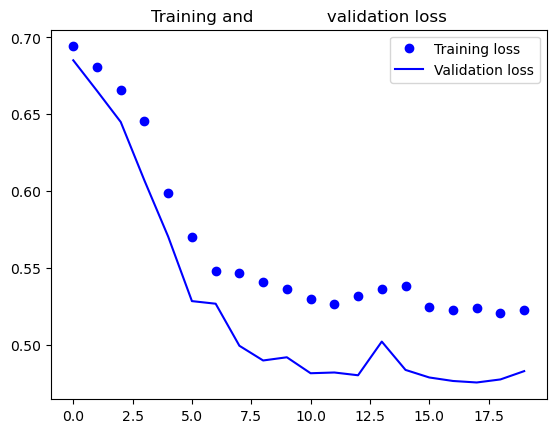

Validation accuracy:  0.7705262899398804


In [35]:
# BiGRU(32) baseline model, one-hot encoding

bigru_32_model=keras.models.Sequential([
    keras.layers.Bidirectional(keras.layers.GRU(32)),
    keras.layers.Dense(1, activation="sigmoid")])

early_stopping=tensorflow.keras.callbacks.EarlyStopping("val_loss",patience=5,restore_best_weights=True)

bigru_32_model.compile(optimizer="adam", loss="binary_crossentropy", metrics=["accuracy"])
history=bigru_32_model.fit(x_training_onehot, y_training,
        epochs=20,
        batch_size=128,
        validation_split=0.2,
        callbacks=[early_stopping])
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(len(loss))
pyplot.plot(epochs, loss, 'bo', label='Training loss')
pyplot.plot(epochs, val_loss, 'b', label='Validation loss')
pyplot.title('Training and \
             validation loss')
pyplot.legend()
pyplot.show()

best_accuracy=history.history['val_accuracy'][numpy.argmin(history.history["val_loss"])]
print("Validation accuracy: ", best_accuracy)

In [23]:
# Bayesian optimization

def build_model(hp):
    embedding_output_dimensions=hp.Choice("embedding output dimensions", [4,16,32])
    bigru_layers=hp.Int("BiGRU layers", min_value=1, max_value=4)
    bigru_units=hp.Choice("BiGRU units", [32,64,128])
    dropout_rate=hp.Float("dropout rate", min_value=0.0, max_value=0.4, step=0.1)
    dense_layers=hp.Int("dense layers", min_value=1, max_value=5)
    learning_rate=hp.Choice('learning_rate', values=[1e-2, 1e-3])
    
    input_layer=keras.layers.Input(shape=x_training_3mer.shape[1:])
    last_layer=input_layer
    last_layer=keras.layers.Embedding(input_dim=32, output_dim=embedding_output_dimensions, input_length=x_training_3mer.shape[1])(last_layer)
    
    for bigru_layer_index in range(bigru_layers):
        if bigru_layer_index==bigru_layers-1:
            last_layer=keras.layers.Bidirectional(keras.layers.GRU(bigru_units, return_sequences=False))(last_layer)
        else:
            last_layer=keras.layers.Bidirectional(keras.layers.GRU(bigru_units, return_sequences=True))(last_layer)
    if dropout_rate>0:
        last_layer=keras.layers.Dropout(dropout_rate)(last_layer)
    last_layer=keras.layers.BatchNormalization()(last_layer)
    for dense_layer_index in range(dense_layers-1):
        last_layer=keras.layers.Dense(16*2**(dense_layers-dense_layer_index-2))(last_layer)
        last_layer=keras.layers.BatchNormalization()(last_layer)
    last_layer=keras.layers.Dense(units=1, activation="sigmoid")(last_layer)
    
    model=keras.Model(inputs=input_layer, outputs=last_layer)
    early_stopping=tensorflow.keras.callbacks.EarlyStopping("val_loss",patience=5,restore_best_weights=True)
    model.compile(optimizer=keras.optimizers.Adam(learning_rate),
              loss='binary_crossentropy',
              metrics=['accuracy'])
    return model

In [25]:
tuner = keras_tuner.BayesianOptimization(
    hypermodel=build_model,
    objective='val_loss',
    executions_per_trial=2,
    directory='output',
    overwrite=True,
    max_trials=45,
    num_initial_points=12,
    project_name='BiGRU model'
)
early_stopping=tensorflow.keras.callbacks.EarlyStopping("val_loss",patience=5,restore_best_weights=True)
tuner.search(x_training_3mer, y_training,
             batch_size=128,
             validation_split=0.2,
             epochs=25, 
             callbacks=[early_stopping])

Trial 45 Complete [00h 00m 50s]
val_loss: 0.5343820750713348

Best val_loss So Far: 0.45300956070423126
Total elapsed time: 00h 45m 55s
INFO:tensorflow:Oracle triggered exit


In [35]:
optimized_model=tuner.get_best_models(num_models=1)[0]
optimized_model.save("optimized_model.keras")
best_hyperparameters=tuner.get_best_hyperparameters()[0].values
print("Best values of hyperparameters:")
for parameter_name, parameter_value in best_hyperparameters.items():
    print(f"{parameter_name}: {parameter_value}")

Best values of hyperparameters:
embedding output dimensions: 4
BiGRU layers: 2
BiGRU units: 32
dropout rate: 0.30000000000000004
dense layers: 3
learning_rate: 0.01


In [30]:
# Print model architecture
optimized_model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 197)]             0         
                                                                 
 embedding (Embedding)       (None, 197, 4)            128       
                                                                 
 bidirectional (Bidirectiona  (None, 197, 64)          7296      
 l)                                                              
                                                                 
 bidirectional_1 (Bidirectio  (None, 64)               18816     
 nal)                                                            
                                                                 
 dropout (Dropout)           (None, 64)                0         
                                                                 
 batch_normalization (BatchN  (None, 64)               256   

In [25]:
# Best model test accuracy
best_accuracy=optimized_model.evaluate(x_test_3mer, y_test)[1]
print("Best model accuracy: ", best_accuracy)

19/19 [==============================] - 2s 17ms/step - loss: 0.5057 - accuracy: 0.7609
Best model accuracy:  0.7609427571296692


In [29]:
# Get confusion matrix

from sklearn.metrics import confusion_matrix

y_predictions=optimized_model.predict(x_test_3mer)
y_predictions=numpy.floor(2*y_predictions)
print(confusion_matrix(y_test, y_predictions))

19/19 [==============================] - 0s 15ms/step
[[235  47]
 [ 95 217]]


Epoch 1/25
15/15 [==============================] - 9s 126ms/step - loss: 0.7077 - accuracy: 0.5919 - val_loss: 0.8740 - val_accuracy: 0.7368
Epoch 2/25
15/15 [==============================] - 1s 53ms/step - loss: 0.6609 - accuracy: 0.6251 - val_loss: 1.2614 - val_accuracy: 0.4737
Epoch 3/25
15/15 [==============================] - 1s 53ms/step - loss: 0.6279 - accuracy: 0.6551 - val_loss: 0.7531 - val_accuracy: 0.7116
Epoch 4/25
15/15 [==============================] - 1s 54ms/step - loss: 0.5745 - accuracy: 0.6919 - val_loss: 0.6479 - val_accuracy: 0.7600
Epoch 5/25
15/15 [==============================] - 1s 54ms/step - loss: 0.5559 - accuracy: 0.7188 - val_loss: 0.5153 - val_accuracy: 0.7621
Epoch 6/25
15/15 [==============================] - 1s 54ms/step - loss: 0.5329 - accuracy: 0.7441 - val_loss: 0.4937 - val_accuracy: 0.7495
Epoch 7/25
15/15 [==============================] - 1s 53ms/step - loss: 0.5168 - accuracy: 0.7536 - val_loss: 0.4610 - val_accuracy: 0.7853
Epoch 8/25
1

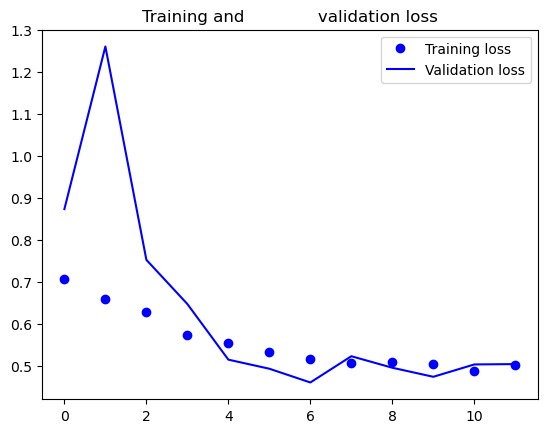

19/19 [==============================] - 0s 16ms/step - loss: 0.5297 - accuracy: 0.7407
Model 1 test accuracy:  0.7407407164573669
Epoch 1/25
15/15 [==============================] - 10s 166ms/step - loss: 0.5224 - accuracy: 0.7525 - val_loss: 0.4869 - val_accuracy: 0.7895
Epoch 2/25
15/15 [==============================] - 1s 53ms/step - loss: 0.5071 - accuracy: 0.7536 - val_loss: 0.5585 - val_accuracy: 0.7811
Epoch 3/25
15/15 [==============================] - 1s 54ms/step - loss: 0.5029 - accuracy: 0.7551 - val_loss: 0.5587 - val_accuracy: 0.7642
Epoch 4/25
15/15 [==============================] - 1s 53ms/step - loss: 0.4998 - accuracy: 0.7578 - val_loss: 0.6285 - val_accuracy: 0.7242
Epoch 5/25
15/15 [==============================] - 1s 53ms/step - loss: 0.4966 - accuracy: 0.7688 - val_loss: 0.5128 - val_accuracy: 0.7853
Epoch 6/25
15/15 [==============================] - 1s 53ms/step - loss: 0.4939 - accuracy: 0.7678 - val_loss: 0.4586 - val_accuracy: 0.7895
Epoch 7/25
15/15 [===

In [11]:
# Train three instances of the model

layers_list=[keras.layers.Input(shape=x_training_3mer.shape[1:])]
layers_list+=[keras.layers.Embedding(input_dim=32, output_dim=4, input_length=x_training_3mer.shape[1])]
layers_list+=[keras.layers.Bidirectional(keras.layers.GRU(32, return_sequences=True))]
layers_list+=[keras.layers.Bidirectional(keras.layers.GRU(32, return_sequences=False))]
layers_list+=[keras.layers.Dropout(0.3)]
layers_list+=[keras.layers.BatchNormalization()]
dense_layers=3
for dense_layer_index in range(dense_layers-1):
        layers_list+=[keras.layers.Dense(16*2**(dense_layers-dense_layer_index-2))]
        layers_list+=[keras.layers.BatchNormalization()]
layers_list+=[keras.layers.Dense(units=1, activation="sigmoid")]
learning_rate=0.01
early_stopping=tensorflow.keras.callbacks.EarlyStopping("val_loss",patience=5,restore_best_weights=True)

optimized_model_1=keras.models.Sequential(layers_list)
optimized_model_1.compile(optimizer=keras.optimizers.Adam(learning_rate),
          loss='binary_crossentropy',
          metrics=['accuracy'])
history_1=optimized_model_1.fit(x_training_3mer, y_training,
             batch_size=128,
             validation_split=0.2,
             epochs=25, 
             callbacks=[early_stopping])
loss = history_1.history['loss']
val_loss = history_1.history['val_loss']
epochs = range(len(loss))
pyplot.plot(epochs, loss, 'bo', label='Training loss')
pyplot.plot(epochs, val_loss, 'b', label='Validation loss')
pyplot.title('Training and \
             validation loss')
pyplot.legend()
pyplot.show()
accuracy_1=optimized_model_1.evaluate(x_test_3mer, y_test)[1]
print("Model 1 test accuracy: ", accuracy_1)

optimized_model_2=keras.models.Sequential(layers_list)
optimized_model_2.compile(optimizer=keras.optimizers.Adam(learning_rate),
          loss='binary_crossentropy',
          metrics=['accuracy'])
history_2=optimized_model_2.fit(x_training_3mer, y_training,
             batch_size=128,
             validation_split=0.2,
             epochs=25, 
             callbacks=[early_stopping])
accuracy_2=optimized_model_2.evaluate(x_test_3mer, y_test)[1]
print("Model 2 test accuracy: ", accuracy_2)

optimized_model_3=keras.models.Sequential(layers_list)
optimized_model_3.compile(optimizer=keras.optimizers.Adam(learning_rate),
          loss='binary_crossentropy',
          metrics=['accuracy'])
history_3=optimized_model_2.fit(x_training_3mer, y_training,
             batch_size=128,
             validation_split=0.2,
             epochs=25, 
             callbacks=[early_stopping])
accuracy_3=optimized_model_3.evaluate(x_test_3mer, y_test)[1]
print("Model 2 test accuracy: ", accuracy_3)

In [12]:
# Calculate average test accuracy
average_test_accuracy = (accuracy_1 + accuracy_2 + accuracy_3) / 3
print("Average test accuracy: ", average_test_accuracy)

Average test accuracy:  0.7502805789311727


In [14]:
# Comparison with baseline

bigru_32_model=keras.models.Sequential([
    keras.layers.Bidirectional(keras.layers.GRU(32)),
    keras.layers.Dense(1, activation="sigmoid")])

early_stopping=tensorflow.keras.callbacks.EarlyStopping("val_loss",patience=5,restore_best_weights=True)

bigru_32_model.compile(optimizer="adam", loss="binary_crossentropy", metrics=["accuracy"])
history=bigru_32_model.fit(x_training_onehot, y_training,
        epochs=20,
        batch_size=128,
        validation_split=0.2,
        callbacks=[early_stopping])
baseline_test_accuracy=bigru_32_model.evaluate(x_test_onehot, y_test)[1]
print("Baseline test accuracy: ", baseline_test_accuracy)

Epoch 1/20
15/15 [==============================] - 4s 63ms/step - loss: 0.6810 - accuracy: 0.5708 - val_loss: 0.6573 - val_accuracy: 0.6505
Epoch 2/20
15/15 [==============================] - 0s 25ms/step - loss: 0.6671 - accuracy: 0.6119 - val_loss: 0.6401 - val_accuracy: 0.6695
Epoch 3/20
15/15 [==============================] - 0s 25ms/step - loss: 0.6500 - accuracy: 0.6440 - val_loss: 0.6066 - val_accuracy: 0.6989
Epoch 4/20
15/15 [==============================] - 0s 25ms/step - loss: 0.6110 - accuracy: 0.6756 - val_loss: 0.5246 - val_accuracy: 0.7432
Epoch 5/20
15/15 [==============================] - 0s 25ms/step - loss: 0.5629 - accuracy: 0.7256 - val_loss: 0.5247 - val_accuracy: 0.7347
Epoch 6/20
15/15 [==============================] - 0s 25ms/step - loss: 0.5487 - accuracy: 0.7330 - val_loss: 0.4989 - val_accuracy: 0.7411
Epoch 7/20
15/15 [==============================] - 0s 25ms/step - loss: 0.5414 - accuracy: 0.7425 - val_loss: 0.4983 - val_accuracy: 0.7579
Epoch 8/20
15